In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
# generate fake background 
n_bkg = 100000

bkg = Tree([])
bkg.color = 'lightgrey'
bkg.extend(x=np.random.exponential(scale=100, size=n_bkg), scale=np.ones(n_bkg)/lumiMap[2018][0])

0it [00:00, ?it/s]

[WARNING] unable to open any files.


In [3]:
# generate fake signal
n_sig = 10000
n_mass = 10
mass_points = np.linspace(125, 300, n_mass)

signal = ObjIter([Tree([], report=False) for m in mass_points])
for mass, s in zip(mass_points, signal):
    s.is_signal = True
    s.extend(x=np.random.normal(loc=mass, scale=mass*10/125, size=n_sig), scale=np.ones(n_sig)/lumiMap[2018][0])


[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.
[WARNING] unable to open any files.


100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


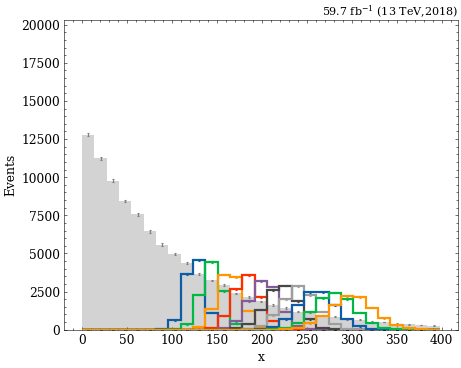

In [4]:
histos = obj_store()
study.quick(
    signal + [bkg],
    varlist=['x'],
    store=histos,
    # efficiency=True,
)

In [5]:
h_bkg = histos[0][0].get_histo()

In [6]:
h_sigs = histos[0][1:]

In [7]:
sig_models = ObjIter([ Model(h_sig, h_bkg) for h_sig in h_sigs ])

In [8]:
serial_limits = [ model.upperlimit() for model in tqdm(sig_models) ]

# this takes too long 

100%|██████████| 10/10 [01:58<00:00, 11.82s/it]


In [10]:
# now lets try a parallel version

import multiprocessing as mp

with mp.pool.Pool(8) as pool:  
    parallel_limits = list(tqdm(pool.imap(Model.upperlimit, sig_models, chunksize=1), total=len(sig_models)))

100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


In [12]:
serial_limits = [ model.h_sig.stats.exp_limits[2] for model in serial_limits ]
parallel_limits = [ model.h_sig.stats.exp_limits[2] for model in parallel_limits ]


(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

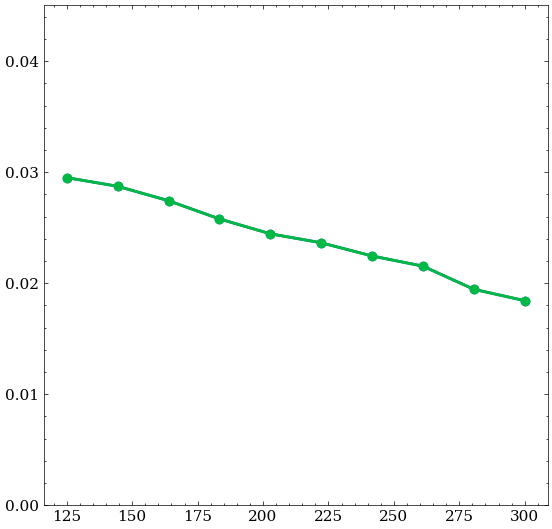

In [13]:
graph_array(mass_points, serial_limits)
graph_array(mass_points, parallel_limits, figax='same')

In [ ]:
import multiprocessing as mp

def pool_apply(self, obj_function, report=False, pool=None):
    if pool is None:
        pool = mp.pool.ThreadPool()

    result = pool.imap(obj_function, self.objs, chunksize=len(self)//pool._processes)

    if report:
        result = tqdm(result, total=len(self))

    results = list( result )

    return ObjIter(results)

In [ ]:
points = ObjIter(mass_points)

In [ ]:
pool_apply(
    points,
    
)

[15625.0, 16530.612244897962, 17461.73469387755, 18418.36734693878, 19400.51020408163, 20408.163265306124, 21441.32653061225, 22500.0, 23584.18367346939, 24693.877551020407, 25829.081632653062, 26989.795918367345, 28176.020408163266, 29387.75510204082, 30625.0, 31887.75510204082, 33176.02040816326, 34489.79591836735, 35829.081632653055, 37193.87755102041, 38584.18367346939, 40000.0, 41441.32653061224, 42908.16326530613, 44400.510204081635, 45918.36734693877, 47461.73469387755, 49030.612244897966, 50625.0, 52244.897959183676, 53890.306122448994, 55561.224489795924, 57257.65306122448, 58979.5918367347, 60727.04081632654, 62500.0, 64298.46938775511, 66122.44897959182, 67971.9387755102, 69846.93877551024, 71747.44897959185, 73673.46938775512, 75625.0, 77602.04081632652, 79604.59183673467, 81632.6530612245, 83686.22448979595, 85765.306122449, 87869.89795918368, 90000.0]